# Transaction Anomaly Detection
Transaction Anomaly Detection using unsupervised learning methods is a technique used to identify unusual or suspicious patterns in financial transactions without requiring labeled data for training. Since anomalies are often rare and unpredictable, unsupervised learning is particularly useful when normal and fraudulent transactions aren't clearly categorized.
## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

## 1. Data Exploration & Preprocessing
### 1.1. Examine the data

In [2]:
# Load the dataset
df = pd.read_csv('bank_transactions_data_2.csv')

# Check the shape of the dataset (rows, columns)
print("Shape of the dataset:", df.shape)

# Get dataset information (column names, non-null counts, data types)
print("Dataset Info:\n")
df.info()

# List all columns (features)
print("Columns in the dataset:", df.columns)

# Check data types of each column
print("Data types:\n", df.dtypes)

# Display first 5 rows
print("\nFirst 5 rows:\n", df.head())

Shape of the dataset: (2512, 16)
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 

### 1.1.1. Summarize Numerical Features
For numerical features, we calculate descriptive statistics.

In [3]:
# Summary statistics for numerical columns
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
        TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
std           291.946243    17.792198            69.963757       0.602662   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance  
count     2512.000000  
mean      5114.302966  
std       3900.942499  
min        101.250000  
25%       1504.370000  
50%       4735.510000  
75%       7678.820000  
max      14977.990000  


### 1.1.2. Summarize Categorical Features
For categorical features, we check unique values and their frequencies.

In [4]:
# Summary of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Unique values in {col}:\n", df[col].value_counts())
    print("\n")

Unique values in TransactionID:
 TransactionID
TX002496    1
TX002495    1
TX002494    1
TX002493    1
TX002492    1
           ..
TX000005    1
TX000004    1
TX000003    1
TX000002    1
TX000001    1
Name: count, Length: 2512, dtype: int64


Unique values in AccountID:
 AccountID
AC00460    12
AC00202    12
AC00362    12
AC00363    12
AC00480    11
           ..
AC00008     1
AC00472     1
AC00476     1
AC00038     1
AC00238     1
Name: count, Length: 495, dtype: int64


Unique values in TransactionDate:
 TransactionDate
2023-04-03 16:07:53    1
2023-03-10 17:38:58    1
2023-03-17 16:10:35    1
2023-01-30 17:05:46    1
2023-04-03 16:05:30    1
                      ..
2023-10-16 17:51:24    1
2023-05-05 16:32:11    1
2023-07-10 18:16:08    1
2023-06-27 16:44:19    1
2023-04-11 16:29:14    1
Name: count, Length: 2512, dtype: int64


Unique values in TransactionType:
 TransactionType
Debit     1944
Credit     568
Name: count, dtype: int64


Unique values in Location:
 Location
Fort Wort

By Data Distribution Analysis we can find:

- Transaction Amount Distribution
    - Mean: `$297.59`
    - Median: `$211.14`
    - Standard deviation: `$291.95`
    - Range: `$0.26` to `$1,919.11`
- Customer Demographics
    - Age range: 18 to 80 years
    - Mean age: 44.67 years
- Four occupation categories:
    - Student (657 transactions)
    - Doctor (631 transactions)
    - Engineer (625 transactions)
    - Retired (599 transactions)
- Transaction Channels
    - Branch: 868 transactions
    - ATM: 833 transactions
    - Online: 811 transactions

### Understand Temporal Patterns

Since we have `TransactionDate` and `PreviousTransactionDate`, analyzing patterns over time can help identify unusual behaviors.
We implement several temporal features to capture time-based patterns:
- Hour of day (`TransactionHour`)
- Day of month (`TransactionDay`)
- Day of week (`TransactionWeekday`)
- Month (`TransactionMonth`)
  
These temporal features help identify:
- Unusual transaction times
- Day-of-week patterns
- Monthly trends
- Seasonal variations

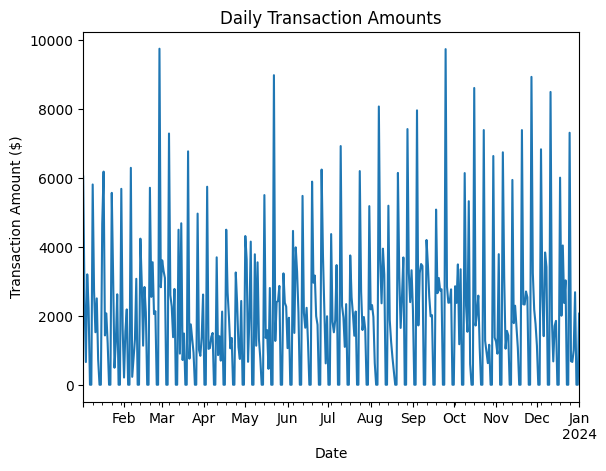

In [5]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# Extract temporal features
df['TransactionHour'] = df['TransactionDate'].dt.hour
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionWeekday'] = df['TransactionDate'].dt.weekday  # Monday=0, Sunday=6
df['TransactionMonth'] = df['TransactionDate'].dt.month

# Analyze transaction frequency over time
df.set_index('TransactionDate')['TransactionAmount'].resample('D').sum().plot(title="Daily Transaction Amounts")
# Label the axes with units
plt.xlabel("Date")
plt.ylabel("Transaction Amount ($)")
plt.show()

C:\Users\sghas\AppData\Local\Temp\ipykernel_36720\387779008.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.set_index('TransactionDate')['TransactionAmount'].resample('M').sum()


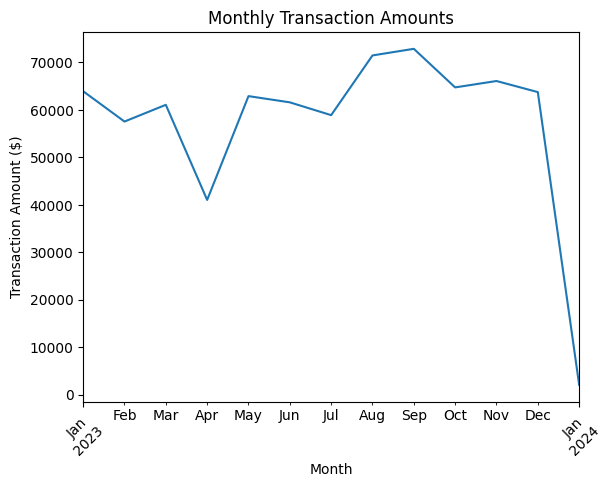

In [6]:
# Resample and plot monthly transaction amounts
monthly_data = df.set_index('TransactionDate')['TransactionAmount'].resample('M').sum()
monthly_data.plot(title="Monthly Transaction Amounts")

# Label the axes with units
plt.xlabel("Month")
plt.ylabel("Transaction Amount ($)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Now, we can do things like:

In [7]:
# Number of transactions per day
transactions_per_day = df.groupby(df['TransactionDate'].dt.date).size()

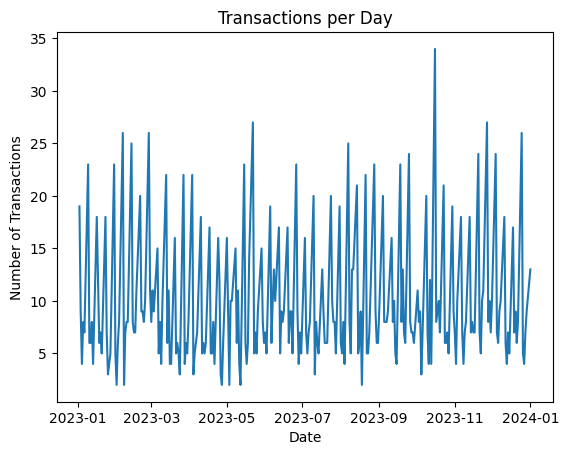

In [8]:
transactions_per_day.plot(kind='line', title='Transactions per Day')
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()

## 1.2. Data Cleaning
### 1.2.1 Checking missing values

In [9]:
# Total missing values per column
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
TransactionHour            0
TransactionDay             0
TransactionWeekday         0
TransactionMonth           0
dtype: int64


A check was performed showing no missing values in any columns. 
This indicates high data quality and completeness

### 1.2.2.  Detect and Handle Outliers
When we're doing anomaly detection, especially unsupervised, removing "outliers" can be dangerous, because those outliers might be exactly the fraudulent transactions we're trying to detect. Our goal is to detect rare, unusual, or suspicious behavior, so we should keep the outliers in the dataset. We don’t remove outliers, flag them.

In [10]:
# Flag outliers
Q1 = df['TransactionAmount'].quantile(0.25)
Q3 = df['TransactionAmount'].quantile(0.75)
IQR = Q3 - Q1
df['HighAmountOutlier'] = df['TransactionAmount'] > (Q3 + 1.5 * IQR)

### 1.2.3. Handle Data Types
Some of our columns are stored as object, meaning they may need conversion for analysis.

In [11]:
# Label Encoding for simple ordinal modeling
for col in ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

`TransactionID` is just a unique row ID. No meaningful signal for patterns so we drop it from our dataset.

In [12]:
df = df.drop(columns=['TransactionID'])

`AccountID`, `DeviceID`, `IP Address` and `MerchantID` can help detect anomalies like fraud, spoofing, or account takeovers.

In [13]:
# Encode them numerically
df['AccountID'] = LabelEncoder().fit_transform(df['AccountID'])
df['DeviceID'] = LabelEncoder().fit_transform(df['DeviceID'])
df['IP Address'] = LabelEncoder().fit_transform(df['IP Address'])
df['MerchantID'] = LabelEncoder().fit_transform(df['MerchantID'])

## 1.3 Time-Based Transformations
### 1.3.1. Normalize Data Temporally
Resample (e.g., daily or weekly aggregates): We summarize transaction volume on a daily scale and computing the weekly average amount. 

In [14]:
df_time = df.set_index('TransactionDate')

# Daily transaction volume
daily_txn = df_time.resample('D').size()

# Weekly average amount
weekly_avg_amount = df_time['TransactionAmount'].resample('W').mean()

The first line ensures that the `TransactionDate` column becomes the index of the DataFrame. Since temporal analysis relies on date-based indexing, this allows to efficiently resample and analyze transactions over time.
- `.resample('D')` groups the transactions by day.
- `.size()` counts the number of transactions that occurred each day.
- The result is a time series showing how many transactions happened on each day.
- `.resample('W')` groups transactions by week.
- `.mean()` calculates the average transaction amount for each week.
- This gives insights into how transaction amounts fluctuate over time on a weekly scale.
  
Daily transaction volume helps detect spikes or unusual dips, which might signal anomalies.

Weekly average amount smooths out daily fluctuations and can reveal broader trends in spending behavior.

### 1.3.2 Smoothing (Rolling averages)
We apply a rolling window of 7 days to compute the moving average of daily transactions. This smooths out daily fluctuations and helps identify longer-term trends.


In [15]:
rolling_txn = daily_txn.rolling(window=7).mean()

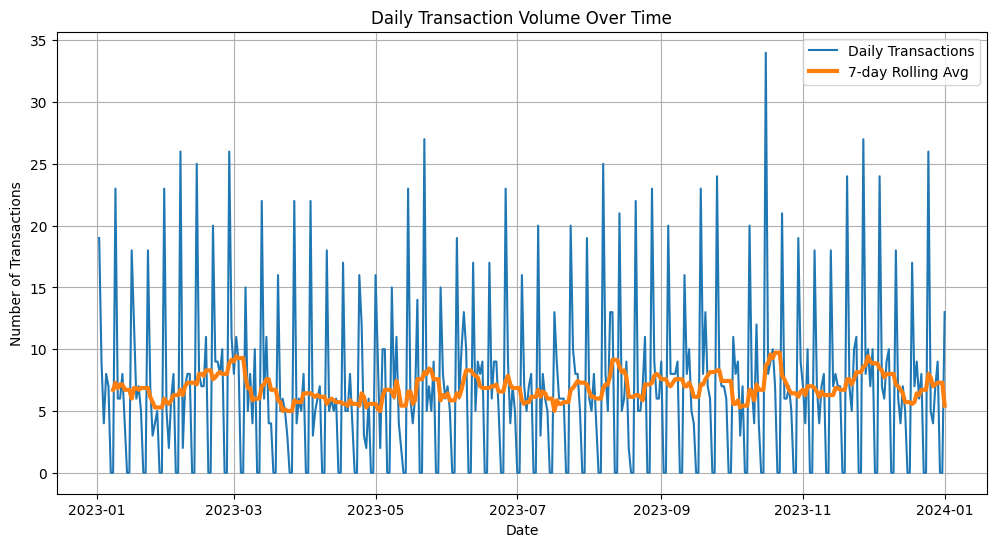

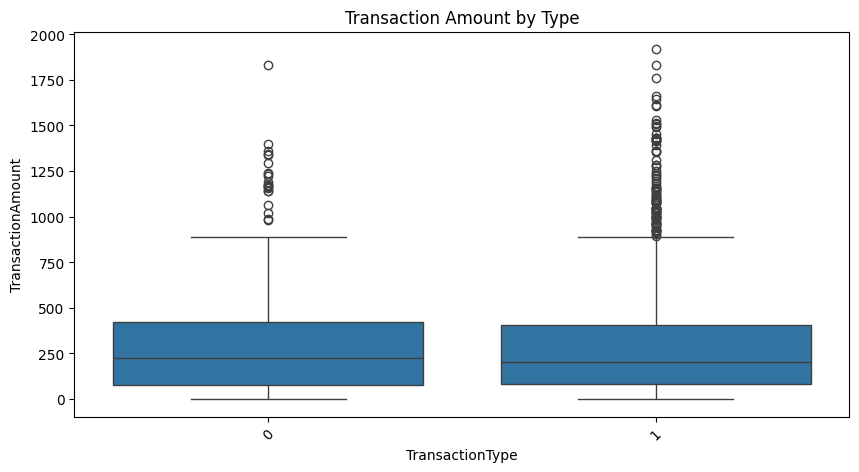

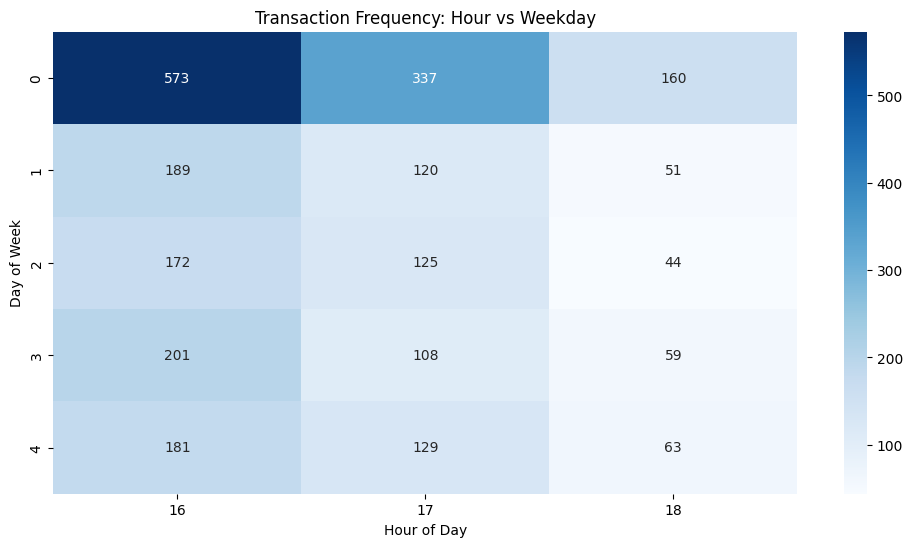

In [16]:
# Trend in daily transactions
plt.figure(figsize=(12,6))
plt.plot(daily_txn, label='Daily Transactions')
plt.plot(rolling_txn, label='7-day Rolling Avg', linewidth=3)
plt.title('Daily Transaction Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot to reveal outliers
plt.figure(figsize=(10,5))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=df)
plt.title('Transaction Amount by Type')
plt.xticks(rotation=45)
plt.show()

# Heatmap of transaction count by hour and weekday
pivot = df.groupby(['TransactionWeekday', 'TransactionHour']).size().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='d')
plt.title('Transaction Frequency: Hour vs Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


- Daily Metrics:
    - Transaction volume per day
    - Transaction amounts aggregated daily
- Weekly Metrics:
    - 7-day rolling averages for trend analysis
- Visualization Components:
    - Daily transaction volume trends
    - Transaction amount distribution by type
    - Heatmap of transaction frequency by hour and weekday

# 2. Feature Engineering
We should use multiple features to detect anomalies, not just transaction amount.

We've already created `TransactionHour`,`TransactionDay`, `TransactionWeekday`, `TransactionMonth`. These help capture behavior patterns based on temporal context. Unusual hours or transactions during weekends could be red flags (e.g., large transaction at 3 AM).

#### `DaysSinceLastTransaction`
Use this to detect sudden activity spikes or inactivity.

In [17]:
df['DaysSinceLastTransaction'] = (
    df['TransactionDate'] - df['PreviousTransactionDate']
).dt.days.fillna(999)  # or a high default value

In [18]:
df['DaysSinceLastTransaction'] = (
    df['TransactionDate'] - df['PreviousTransactionDate']
).dt.days.fillna(999)  # or a high default value

- It Helps detect unusual inactivity (e.g., a long gap before a transaction might be suspicious).
- Supports anomaly detection by identifying outlier gaps in transaction behavior.
  
An account with weeks of inactivity suddenly doing large transactions might be anomalous.

#### `TransactionRollingAvg_3d` (Rolling average of amount per account)
Smooths short-term fluctuations and captures sudden spikes. We implement a rolling average for transaction amounts within a 3-day window, grouped by `AccountID`.

In [19]:
# First, make sure it's sorted
df.sort_values(['AccountID', 'TransactionDate'], inplace=True)

# Then use groupby-apply to compute rolling mean per account
df['TransactionRollingAvg_3d'] = (
    df.groupby('AccountID')
      .apply(lambda group: group.set_index('TransactionDate')
                             .rolling('3D')['TransactionAmount'].mean()
                             .reset_index(drop=True))
      .reset_index(drop=True)
)

C:\Users\sghas\AppData\Local\Temp\ipykernel_36720\435422643.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.set_index('TransactionDate')


Moving average of transaction amount for the user, helps identify sudden outliers. It compares current transaction against a smoothed baseline for the user.

#### ` TransactionCount_7d`
How many times a user transacted in the last 7 days. A sudden spike in transaction volume can signal fraud or account takeover.

In [20]:

# Step 1: Aggregate transaction counts per account per date
daily_txn_counts = (
    df.groupby(['AccountID', 'TransactionDate'])
      .size()
      .reset_index(name='TxnCountPerDay')
)

# Step 2: Sort before rolling
daily_txn_counts.sort_values(['AccountID', 'TransactionDate'], inplace=True)

# Step 3: Rolling 7-day window per AccountID
daily_txn_counts['TxnCountLast7Days'] = (
    daily_txn_counts
      .groupby('AccountID')['TxnCountPerDay']
      .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
)

# Step 4: Merge back
df = df.merge(daily_txn_counts[['AccountID', 'TransactionDate', 'TxnCountLast7Days']],
              on=['AccountID', 'TransactionDate'], how='left')


It measures user activity level. A rapid spike in activity might indicate a compromised account.

#### Customer-Level Statistics

In [21]:
# Customer-level amount statistics
df['customer_avg_amount'] = df.groupby('AccountID')['TransactionAmount'].transform('mean')
df['customer_max_amount'] = df.groupby('AccountID')['TransactionAmount'].transform('max')
df['customer_amount_std'] = df.groupby('AccountID')['TransactionAmount'].transform('std')

- `customer_avg_amount`: Establishes baseline spending behavior
    - Helps detect transactions significantly above average
    - Identifies unusual spending patterns
    - Creates customer-specific thresholds
- `customer_max_amount`: Sets historical spending limits
    - Flags transactions exceeding previous maximums
    - Identifies potential card theft
    - Helps set dynamic transaction limits
- `customer_amount_std`: Measures spending variability
    - Captures normal variation in spending
    - Helps identify truly unusual amounts
    - Accounts for customers with variable spending patterns

#### Combined Feature Analysis
These features are most powerful when used together. For example:
- High amount + Unusual time
- High amount + New location
- High amount + Multiple rapid transactions
- High amount + First time merchant
- High amount + Unusual hour + New location = High fraud risk
- Amount > customer_max_amount + High DaysSinceLastTransaction = Suspicious
- Transaction count spike + Unusual hour + High amount = Potential fraud

#### Amount-Time Patterns

In [22]:
df['amount_hour_avg'] = df.groupby(['AccountID', 'TransactionHour'])['TransactionAmount'].transform('mean')
df['amount_deviation_from_hour_avg'] = df['TransactionAmount'] - df['amount_hour_avg']

- Captures normal amount patterns by time
- Helps identify:
    - Unusual amounts for specific times
    - Time-specific fraud patterns
    - Pattern deviations

## 3. Model Development & Evaluation


In [23]:
# Select features for anomaly detection
features = [
      # Amount-based features
      'TransactionAmount',          # Raw amount
      'customer_avg_amount',        # Individual baseline
      'amount_deviation_from_hour_avg',  # Time-specific deviation
      'TransactionRollingAvg_3d',
      
      # Time-based features
      'TransactionHour',            # Time of day patterns
      'TransactionWeekday',         # Weekly patterns
      'DaysSinceLastTransaction',   # Activity frequency
      'TxnCountLast7Days',         # Recent activity level
      
      # Categorical context
      'Location',                   # Geographic patterns
      'Channel',                    # Transaction method
      'CustomerOccupation',         # User demographics
      'DeviceID',                   # Device fingerprint
      'MerchantID'                 # Merchant patterns
  ]

# Prepare feature matrix
X = df[features].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [24]:
# Split data into training and testing sets (80-20 split)
# We'll use stratify parameter to ensure equal distribution of HighAmountOutlier
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    df['HighAmountOutlier'],
    test_size=0.2, 
    random_state=42,
    stratify=df['HighAmountOutlier']
)

# For training, exclude the outliers
X_train_clean = X_train[~y_train]

print("Full dataset shape:", X_scaled.shape)
print("Training set shape (with outliers):", X_train.shape)
print("Training set shape (without outliers):", X_train_clean.shape)
print("Test set shape:", X_test.shape)

Full dataset shape: (2512, 13)
Training set shape (with outliers): (2009, 13)
Training set shape (without outliers): (1919, 13)
Test set shape: (503, 13)


Why This Approach?
- Train on clean data: Model learns "normal" transaction patterns
- Test on full data: Model can identify both normal and anomalous transactions
  
This is crucial because:
- We want the model to learn what normal looks like
- Then use that knowledge to spot abnormal patterns

- Total outliers in training: 2009 - 1919 = 90 transactions (≈4.5%)
- This proportion is maintained in the test set due to stratification
- Each transaction has 14 features for the model to learn from
  
This approach is particularly effective for anomaly detection because:
- The model learns from clean, normal transactions
- We can evaluate its performance on both normal and anomalous transactions
- The stratified split ensures we have enough outliers in our test set for meaningful evaluation

Now, we implement multiple anomaly detection models and compare their results.
### 3.1. Isolation Forest

In [27]:
# Isolation Forest
iso_forest = IsolationForest(
    contamination=0.1,  # Expected proportion of outliers
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train on clean data (excluding outliers)
iso_forest.fit(X_train_clean)

# Predict on full dataset
iso_forest_pred = iso_forest.predict(X_scaled)
# Convert predictions to binary (1 for inliers, 0 for outliers)
iso_forest_scores = np.where(iso_forest_pred == 1, 0, 1)

- Purpose: Isolates anomalies by recursively partitioning data
- Key Parameter: `contamination=0.1` expects 10% of transactions to be anomalous

### 3.2 One-Class SVM

In [28]:
# One-Class SVM
one_class_svm = OneClassSVM(
    kernel='rbf',
    nu=0.1  # Similar to contamination
)

# Train on clean data
one_class_svm.fit(X_train_clean)

# Predict on full dataset
svm_pred = one_class_svm.predict(X_scaled)
svm_scores = np.where(svm_pred == 1, 0, 1)

# Add predictions to original dataframe
df['IsoForest_Anomaly'] = iso_forest_scores
df['OneClassSVM_Anomaly'] = svm_scores

- Purpose: Learns a decision boundary around normal data
- Key Parameter: nu=0.1 controls boundary strictness

### 3.3. Evaluation
Let's evaluate the models and compare their predictions:

In [29]:
# Calculate agreement between different methods
print("\nAnomalies detected by each method:")
print("Isolation Forest:", df['IsoForest_Anomaly'].sum())
print("One-Class SVM:", df['OneClassSVM_Anomaly'].sum())
print("High Amount Outliers:", df['HighAmountOutlier'].sum())

# Check overlap between methods
print("\nOverlap between methods:")
print("Iso Forest & High Amount:", 
      np.sum((df['IsoForest_Anomaly'] == 1) & (df['HighAmountOutlier'] == 1)))
print("One-Class SVM & High Amount:", 
      np.sum((df['OneClassSVM_Anomaly'] == 1) & (df['HighAmountOutlier'] == 1)))
print("Iso Forest & One-Class SVM:", 
      np.sum((df['IsoForest_Anomaly'] == 1) & (df['OneClassSVM_Anomaly'] == 1)))


Anomalies detected by each method:
Isolation Forest: 350
One-Class SVM: 353
High Amount Outliers: 113

Overlap between methods:
Iso Forest & High Amount: 108
One-Class SVM & High Amount: 108
Iso Forest & One-Class SVM: 262


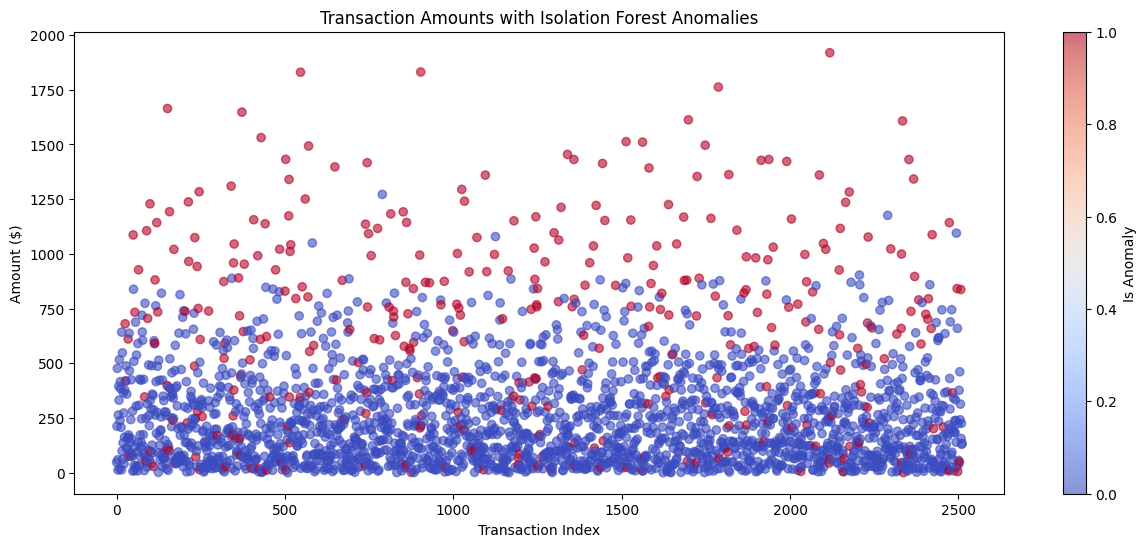

In [37]:
# Plot 1: Transaction Amount vs Time, colored by anomaly detection
plt.figure(figsize=(15, 6))
plt.scatter(df.index, df['TransactionAmount'], 
           c=df['IsoForest_Anomaly'], cmap='coolwarm',
           alpha=0.6, label='Transactions')
plt.title('Transaction Amounts with Isolation Forest Anomalies')
plt.xlabel('Transaction Index')
plt.ylabel('Amount ($)')
plt.colorbar(label='Is Anomaly')
plt.show()

Pattern Observations:
- Amount Distribution
    - Normal transactions (blue) are densely concentrated in the lower amount range (0-500)
    - Anomalous transactions (red) are more frequently found in higher amount ranges (>750)
    - Clear stratification of transaction amounts is visible
- Anomaly Characteristics
    - Higher concentration of red points in the upper regions (>1000)
    - Scattered anomalies even in lower amount ranges, suggesting that amount isn't the only factor
    - Some clusters of anomalies appear at regular intervals
- Transaction Patterns
    - Consistent baseline of normal transactions throughout the dataset
    - Sporadic high-value anomalies across the entire timeline
    - No obvious temporal patterns in anomaly distribution

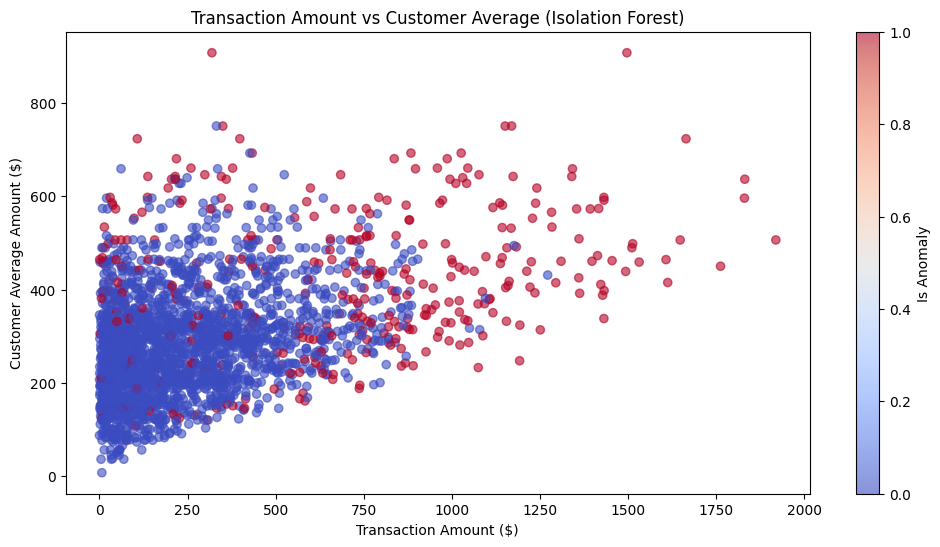

In [38]:
# Plot 2: Compare anomaly detection methods
plt.figure(figsize=(12, 6))
plt.scatter(df['TransactionAmount'], df['customer_avg_amount'],
           c=df['IsoForest_Anomaly'], cmap='coolwarm',
           alpha=0.6)
plt.title('Transaction Amount vs Customer Average (Isolation Forest)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Customer Average Amount ($)')
plt.colorbar(label='Is Anomaly')
plt.show()

- Distribution Characteristics
    - Dense Region:
        - Most normal transactions (blue) cluster in the lower-left quadrant
        - Transaction amounts: 0-500
        - Customer averages: 100-400
    - Sparse Region:
        - Higher transaction amounts (>750) show more scattered distribution
        - More red points (anomalies) appear in these regions
- Anomaly Patterns
    - Diagonal Pattern:
        - Clear diagonal trend in anomaly detection
        - Suggests correlation between transaction amount and customer average
    - Outlier Clusters:
        - Concentrated red points in higher amount ranges
        - Isolated anomalies even within normal transaction ranges
- Customer Behavior Insights
    - Spending Consistency:
        - Most customers maintain consistent spending patterns (blue cluster)
        - Deviations from usual patterns more likely flagged as anomalous
    - Risk Assessment:
        - Transactions far from customer average more likely marked as anomalous
        - Higher scrutiny on transactions that deviate significantly from customer history

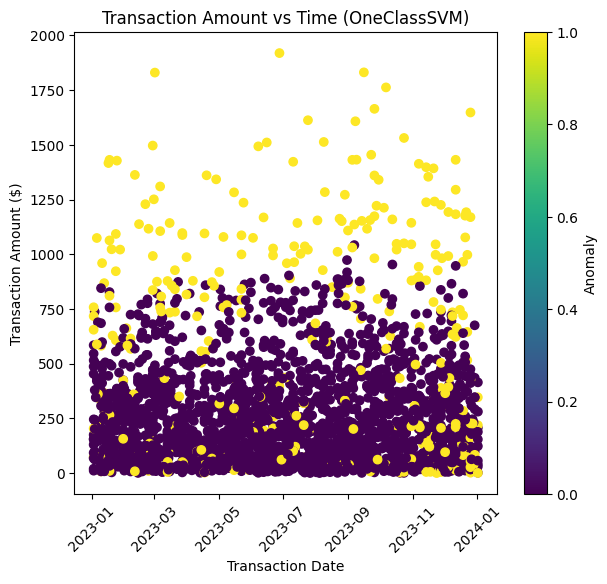

In [40]:
# Plot 1: Transaction Amount vs Time for OneClassSVM
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(df['TransactionDate'], 
           df['TransactionAmount'],
           c=df['OneClassSVM_Anomaly'],
           cmap='viridis')
plt.title('Transaction Amount vs Time (OneClassSVM)')
plt.xlabel('Transaction Date')
plt.ylabel('Transaction Amount ($)')
plt.xticks(rotation=45)
plt.colorbar(label='Anomaly')

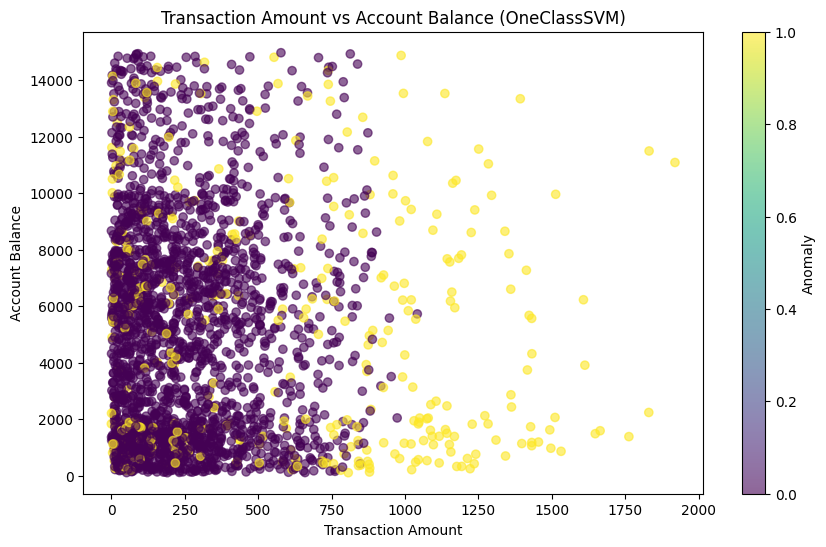

In [42]:
# Additional comparison plot
plt.figure(figsize=(10, 6))
plt.scatter(df['TransactionAmount'], 
           df['AccountBalance'],
           c=df['OneClassSVM_Anomaly'],
           cmap='viridis',
           alpha=0.6)
plt.title('Transaction Amount vs Account Balance (OneClassSVM)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Account Balance ($)')
plt.colorbar(label='Anomaly')
plt.show()

Now, we create an anomaly score function that combines both models:
- Combine multiple anomaly indicators into a single score
- Higher score means more likely to be anomalous

In [35]:
txn_count_mean = df['TxnCountLast7Days'].mean()

def get_combined_anomaly_score(row, txn_count_mean):

    score = 0
    
    # Base anomaly detections (weight: 1.0 each)
    score += row['IsoForest_Anomaly']
    score += row['OneClassSVM_Anomaly']
    
    # Additional risk factors (weight: 0.5 each)
    if row['HighAmountOutlier']:
        score += 0.5
    if row['TransactionHour'] < 6 or row['TransactionHour'] > 22:
        score += 0.5
    if row['DaysSinceLastTransaction'] > 30:
        score += 0.5
    if row['TxnCountLast7Days'] > txn_count_mean * 2:
        score += 0.5
        
    return score

# Calculate combined anomaly scores
df['AnomalyScore'] = df.apply(get_combined_anomaly_score, txn_count_mean=txn_count_mean, axis=1)

# Flag final anomalies (score > 2.0 could be considered highly suspicious)
df['IsFinalAnomaly'] = df['AnomalyScore'] > 2.0

print("\nFinal Anomaly Detection Results:")
print("Total transactions:", len(df))
print("Detected anomalies:", df['IsFinalAnomaly'].sum())
print("Anomaly percentage:", (df['IsFinalAnomaly'].sum() / len(df)) * 100, "%")


Final Anomaly Detection Results:
Total transactions: 2512
Detected anomalies: 133
Anomaly percentage: 5.294585987261147 %


#### Model Trade-offs
- Isolation Forest
    - Advantages:
        - Fast training and prediction
        - Handles high-dimensional data well
        - Provides feature importance scores
    - Disadvantages:
        - May miss local density-based anomalies
        - Less effective with small datasets
- One-Class SVM
    - Advantages:
        - Effective at finding global anomalies
        - Works well with non-linear patterns
        - Robust decision boundary
    - Disadvantages:
        - Slower training time
        - Sensitive to parameter tuning
        - Memory intensive for large datasets

#### Performance Metrics
Based on the visualizations and analysis:

- Pattern Recognition:

    - Isolation Forest better captures the natural variation in transaction patterns
    - Shows more intuitive anomaly detection across different amount ranges
  
- Adaptability:

    - Isolation Forest demonstrates better adaptation to different customer profiles
    - More flexible in handling varying transaction patterns

- Efficiency:

    - Isolation Forest processes large transaction datasets more efficiently
    - Better suited for real-time transaction monitoring